# 1 Introduction

I'm going to understand some Markov Chain Monte Carlo algorithms by implementing it in this notebook. Then I will try to run it on the IRT data I have.

# 2 Metropolis-Hastings

## 2.1 Definition

1. Initialize $\pmb{x}_0$ by choosing an arbitrary point to start with for each parameter, and choose a function $Q(\pmb{x}_c|\pmb{x}_i)$ for the proposal density.
2. For each iteration $i$:
    1. Generate a candidate $\pmb{x}_c$ for the next sample from the proposal density.
$$\pmb{x}_c \sim Q(\pmb{x}_c|\pmb{x}_i)$$
    2. Calculate the acceptance ratio $\alpha$.
$$\alpha = \frac{Likelihood(\pmb{x}_c)Prior(\pmb{x}_c)}{Likelihood(\pmb{x}_i)Prior(\pmb{x}_i)}$$
    3. Generate a random uniform number $u$ on the interval [0,1].
    4. If $u \leq \alpha$, set $\pmb{x}_i = \pmb{x}_c$.

## 2.2 Python Implementation

Likelihood:
$$L(\pmb{\theta},\pmb{b}|\pmb{y}) = \prod_{i=1}^{n}{\prod_{j=1}^{m}{\Bigl[\frac{1}{1+e^{-(\theta_i-b_j)}}\Bigr]^{y_{ij}}\Bigl[1-\frac{1}{1+e^{-(\theta_i-b_j)}}\Bigr]^{1-y_{ij}}}}$$

Proposal Distributions:
$$Q(\pmb{\theta}_c|\pmb{\theta}_i) = \mathcal{N}(\pmb{\theta}_i, 0.25)$$
$$Q(\pmb{b}_c|\pmb{b}_i) = \mathcal{N}(\pmb{b}_i, 0.25)$$

Prior:
$$P(\pmb{\theta},\pmb{b}) = \mathcal{N}(\pmb{\theta}, 1)\mathcal{N}(\pmb{b}, 1)$$

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm

%matplotlib inline

In [15]:
data = pd.read_csv('IRT tutorial/ouirt.dat', sep='\s+', header=None)
data.head()

,0,1,2,3,4,5,6,7,8,9
0,0,1,1,1,1,1,1,1,1,0
1,0,1,0,0,1,0,1,0,0,0
2,0,0,0,0,1,1,1,0,1,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0


In [18]:
# for a single item
y = np.array(data)
n_students = y.shape[0]
n_items = y.shape[1]

print('students:', n_students)
print('items:', n_items)
print('parameters:', n_students+n_items)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def normpdf(x, mu, sigma):
    u = (x-mu)/np.abs(sigma)
    y = (1/(np.sqrt(2*np.pi)*np.abs(sigma)))*np.exp(-u*u/2)
    return y

def logLikelihood(y, theta, b):
    return np.sum(y*np.log(sigmoid(theta - b)) + (1 - y)*np.log(1 - sigmoid(theta - b)))

def prior(theta, b):
    # gaussian prior on theta and b
    p_theta = normpdf(theta, 0, 1)
    p_b = normpdf(b, 2, 3)
    p = np.sum(np.log(p_theta)) + np.sum(np.log(p_b))
    return p

theta = np.random.normal(0, 1, (n_students, 1)) # column vector
b = np.random.normal(0, 1, (1, n_items)) # row vector

accepted_theta = []
accepted_b = []

iterations = 2000000
for i in tqdm(range(iterations)):
    
    theta_new = np.random.normal(theta, 0.25, (n_students, 1))
    b_new = np.random.normal(b, 0.25, (1, n_items))
    
    u = np.random.uniform(0,1)
    a = logLikelihood(y, theta_new, b_new) + prior(theta_new, b_new)\
            - (logLikelihood(y, theta, b) + prior(theta, b))
    
    if u <= a:
        theta = theta_new
        b = b_new
        accepted_theta.append(theta_new)
        accepted_b.append(b_new)
        
print('acceptance rate:', len(accepted_b)/iterations)

students: 500
items: 10
parameters: 510


acceptance rate: 0.0001115


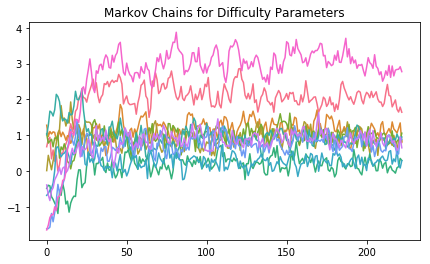

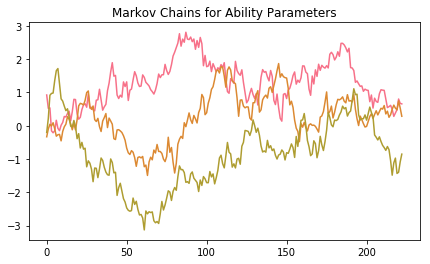

In [71]:
b_chain = pd.DataFrame(np.array(accepted_b).reshape((len(accepted_b), n_items)))
theta_chain = pd.DataFrame(np.array(accepted_theta).reshape((len(accepted_theta), n_students)))

plt.rcParams["figure.figsize"] = (7,4)
sns.set_palette("husl", 10)

plt.title('Markov Chains for Difficulty Parameters')
plt.plot(b_chain)
plt.show()

plt.title('Markov Chains for Ability Parameters')
plt.plot(theta_chain.sample(3, axis='columns'))
plt.show()

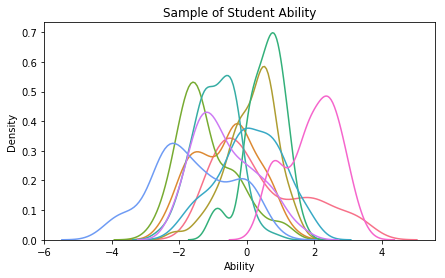

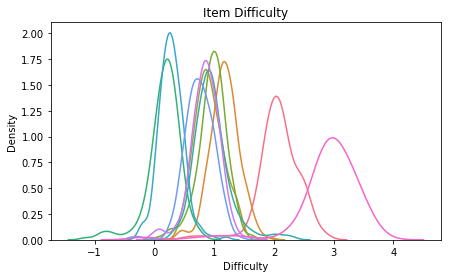

In [34]:
plt.rcParams["figure.figsize"] = (7,4)

for i in np.random.choice(n_students, 10, replace=False):
    sns.distplot(theta_chain.iloc[10:,i], hist = False)
plt.title('Sample of Student Ability')
plt.xlabel('Ability')
plt.ylabel('Density')
plt.show()

for i in range(n_items):
    sns.distplot(b_chain.iloc[10:,i], hist = False)
plt.title('Item Difficulty')
plt.xlabel('Difficulty')
plt.ylabel('Density')
plt.show()

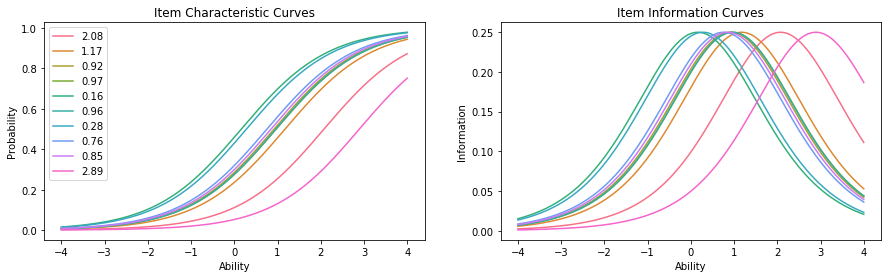

In [28]:
# final values
theta_final = theta_chain.iloc[10:].mean()
b_final = b_chain.iloc[10:].mean()

# item characteristic curve
def icc_1pl(theta, b):
    return 1 / (1 + np.exp(-(theta - b)))

# item information curve
def inf_1pl(p_theta):
    return p_theta * (1 - p_theta)

# plot ICC and IIC
plt.rcParams["figure.figsize"] = (15,4)
sns.set_palette("husl", 10)
f, (ax1, ax2) = plt.subplots(1, 2)

theta = np.linspace(-4, 4, 256, endpoint=True)

for b in b_final:
    p_theta = icc_1pl(theta, b)
    sns.lineplot(theta, p_theta, ax=ax1)
    sns.lineplot(theta, inf_1pl(p_theta), ax=ax2)
    
ax1.set_title('Item Characteristic Curves')
ax1.set_xlabel('Ability')
ax1.set_ylabel('Probability')

ax2.set_title('Item Information Curves')
ax2.set_xlabel('Ability')
ax2.set_ylabel('Information')

ax1.legend(b_final.round(2))

plt.show()

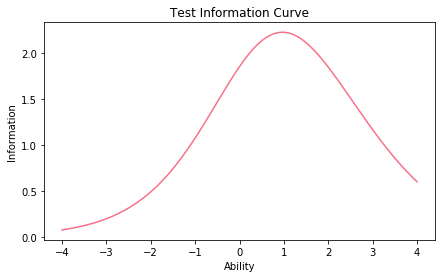

In [35]:
# Test Information Curve

test_inf = []
for b in b_final:
    p_theta = icc_1pl(theta, b)
    test_inf.append(inf_1pl(p_theta))
    
plt.rcParams["figure.figsize"] = (7,4)
plt.plot(theta, np.sum(test_inf, axis=0))

plt.title('Test Information Curve')
plt.xlabel('Ability')
plt.ylabel('Information')

plt.show()